In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import ipywidgets as widgets
import warnings
import pandas as pd
import itertools

from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

In [2]:
# Source: https://www.kaggle.com/code/danbrice/keras-plot-history-full-report-and-grid-search
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Introduction
For this project, we decided to work on an image classification problem using neural networks to solve multi-label classification. Initially, we began by researching different datasets and deciding on a dataset which was generic (not affiliated with any existing IPs) and contained multi-labels.

## The Data
We chose to work on creating a model to classify low-resolution game sprites. For this, we went with the [Pixel Art dataset by Ebrahim Elgazar](https://www.kaggle.com/datasets/ebrahimelgazar/pixel-art). This provides us with a set of 595 sprites to look at.

*For some reason, the original dataset is actually 89,000 images of the same 894 sprites. But, indices from 244 to 543 are downscaled images, so we didn't want to work on those. That leaves use with 595 sprites to work on*

In [3]:
data = np.load('./Dataset1/sprites_labels.npy')
sprites = np.load('./Dataset1/sprites.npy')

y = data[:894]
y = np.delete(y, slice(244, 543), axis=0)
print(y.shape)

X = sprites[:894]
X = np.delete(X, slice(244, 543), axis=0)
print(X.shape)

unique, counts = np.unique(y, return_counts=True, axis=0)
for i in range(len(unique)):
    print(unique[i], counts[i])

(595, 5)
(595, 16, 16, 3)
[0. 0. 0. 0. 1.] 80
[0. 0. 0. 1. 0.] 350
[0. 0. 1. 0. 0.] 60
[0. 1. 0. 0. 0.] 25
[1. 0. 0. 0. 0.] 80


The labels for said data are as follows:
[Character (Front), Monster, Food, Item, Character (Side)]
- Characters (0-159)
    - [1, 0, 0, 0 ,0] - Front Facing
    - [0, 0, 0, 0, 1] - Side Facing
- Monsters (160-183)
    - [0, 1, 0, 0, 0]
- Food (184-243)
    - [0, 0, 1, 0, 0]
- Downscaled Monsters - RED (244-343) *excluded*
    - [0, 1, 0, 0, 0]
- Downscaled Monsters - GREEN (344-443) *excluded*
    - [0, 1, 0, 0, 0]
- Downscaled Monsters - BLUE (444-543) *excluded*
    - [0, 1, 0, 0, 0]
- Items (544-893)
    - [0, 0, 0, 1, 0]

Conveniently, the labels are already in one-hot-encoding form.

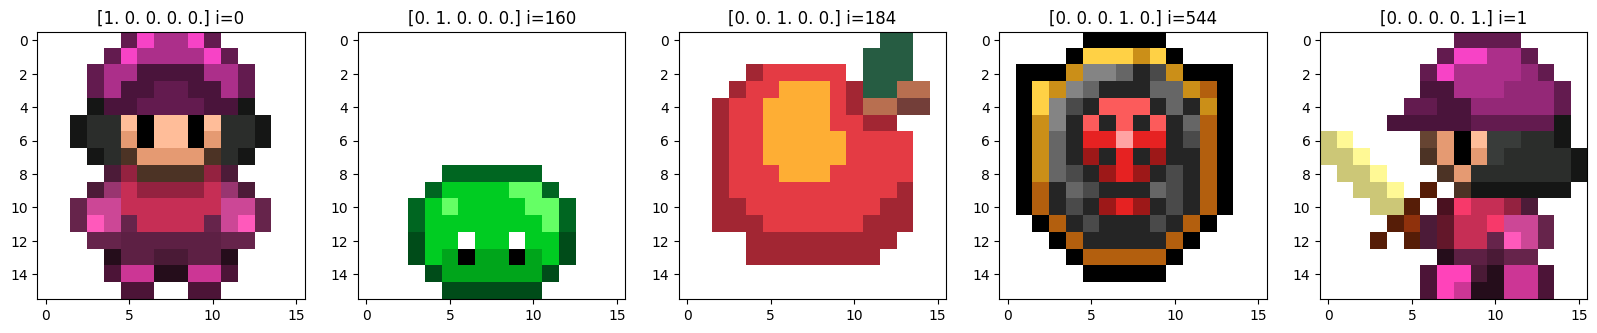

In [4]:
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
indices = [0, 160, 184, 544, 1]
for i in range(5):
    index = indices[i]
    ax[i].imshow(X[index])
    ax[i].set_title(f"{y[index]} i={index}")

By displaying the averages for each label, we can get an idea of common elements for each type:

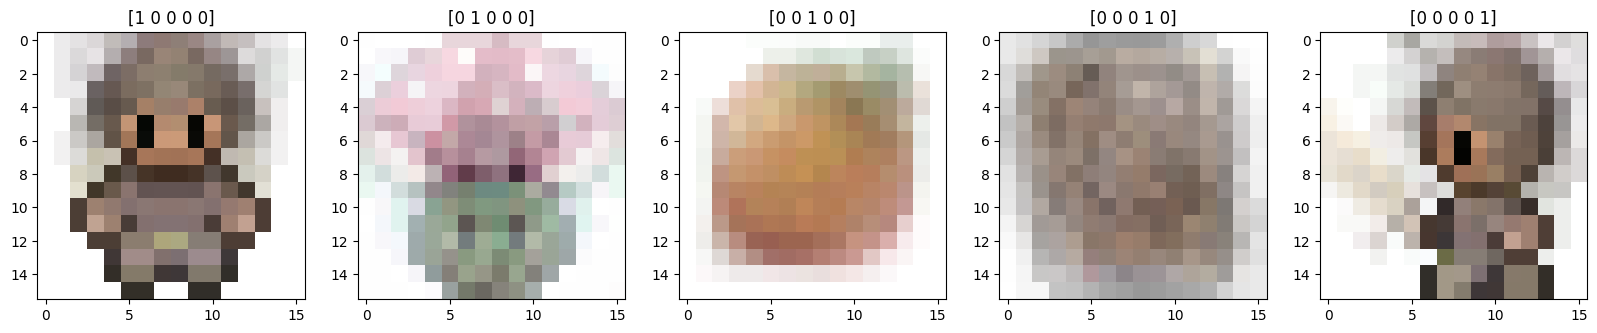

In [5]:
fig, ax = plt.subplots(1, 5, figsize=(20, 20))

labels = np.array([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]])

for i in range(5):
    mask = np.all(y == labels[i], axis=1)
    average = np.sum(X[mask], axis=0) / np.sum(mask)
    average /= 255
    
    ax[i].imshow(average)
    ax[i].set_title(str(labels[i]))

As seen above, the sprites for characters have very strong features that are similar to eachother.

# Building the Model
We decided on using a convolutional neural network because the problem we decided to solve was one of image classification, and a convolutional neural network it adept at processing this kind of task. This is especially the case since recently, convolution layers have led to significant increases in accuracy related to image classification. Additionally, since our dataset contained multiple different classes, so it would make sense to use a classifier which is has flexibility in the process of selecting its parameters.

*A demonstration of what convolution can do to our dataset. Without training, the convolution filters are random.*

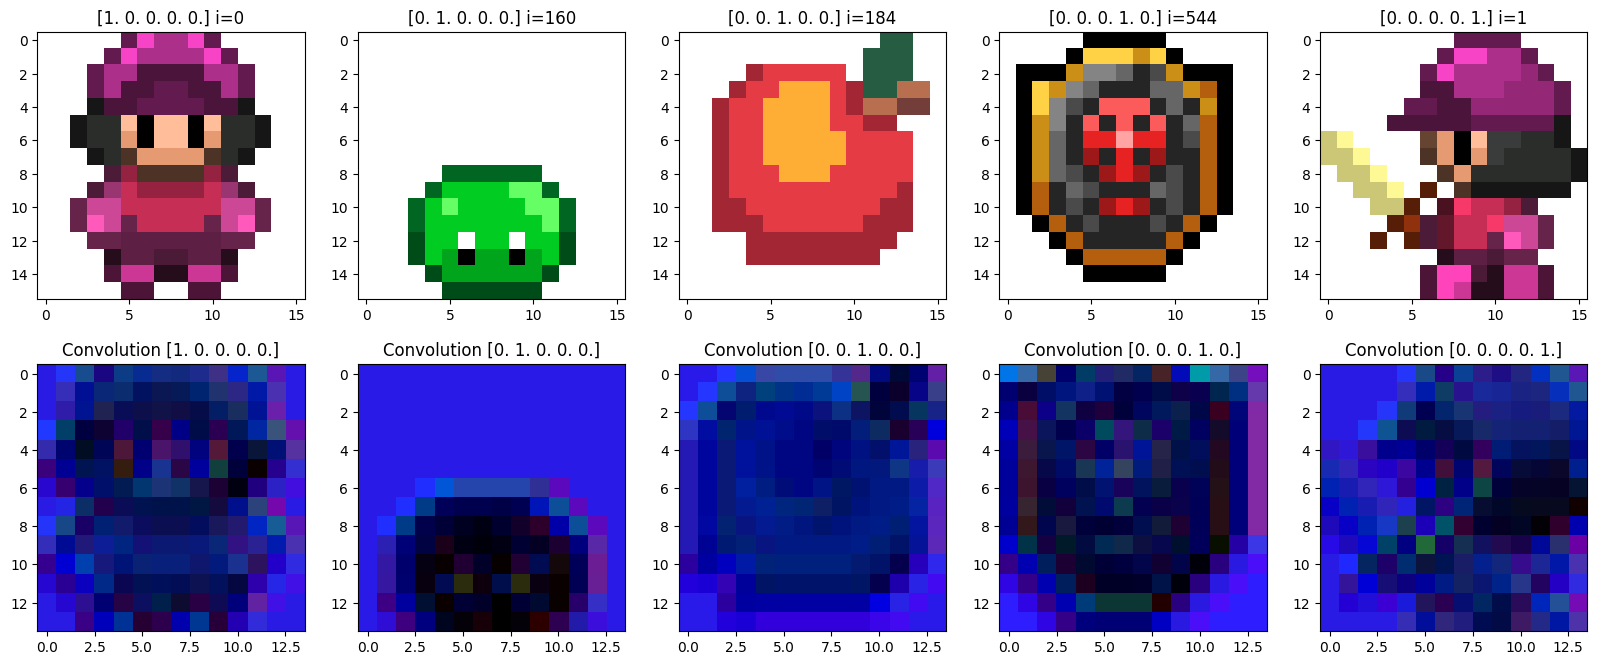

In [6]:
indices = [0, 160, 184, 544, 1]
example_sprites = np.array(X[indices])
keras.utils.set_random_seed(0)

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(3, (3, 3), (1, 1), activation='relu', padding='valid'))

fig, ax = plt.subplots(2, 5, figsize=(20, 20))
fig.subplots_adjust(hspace=-0.725)
for i in range(5):
    ax[0, i].imshow(example_sprites[i])
    ax[0, i].set_title(f"{y[indices[i]]} i={indices[i]}")
    conv_result = model(example_sprites[i][np.newaxis, ...] / 255)
    ax[1, i].imshow(conv_result[0] / np.max(conv_result[0]))
    ax[1, i].set_title(f"Convolution {y[indices[i]]}")

We built our model builder function to be thourough with many different approaches to sort out our neural network.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True, stratify=y)

def create_model(optimizer='adam'):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(16, 16, 3)))
    model.add(keras.layers.Conv2D(3, (3, 3), (1, 1), activation='relu', padding='same'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(5, activation='softmax'))
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

param_grid = {
    #'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30, 40],
    'batch_size': [40, 60, 80],
    #'epochs': [64, 128, 256],
    'optimizer': ['adam', 'rmsprop']
}

model = KerasClassifier(build_fn=create_model, verbose=0, optimizer='adam')

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=0)

grid_result = None
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid_result = grid.fit(X_train, y_train)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

Best: 0.9642677069235465 using {'batch_size': 80, 'epochs': 40, 'optimizer': 'rmsprop'}


## A little bit of trial and error
Through creating layers for our sequential model, we originally thought that upsampling would help improve our model accuracy with it's ability to identify outlines, however, it would severely misclassify characters(front), monsters, and food.

We also found out that the SGD optimizer often misclassified everything as an item. This is probably due to the fact that there are more items than anything else in the dataset and it would settle on classifying everything as such. Same happened with the adadelta optimizer. Both the adam and rmsprop optimizers seem to perform similarly.

In [8]:
grid_result.best_estimator_.model_.summary()

y_pred = grid_result.predict(X_test)
print(f"Test accuracy: {np.mean(y_pred == y_test)}")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 3)      │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,877 (581.55 KB)

 Trainable params: 49,625 (193.85 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,252 (387.71 KB)

Test accuracy: 0.9764705882352941


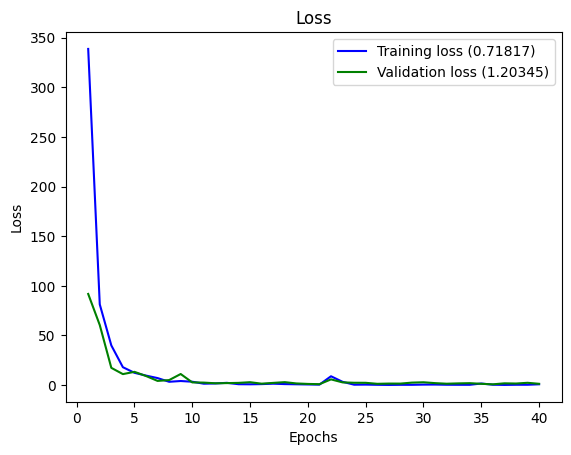

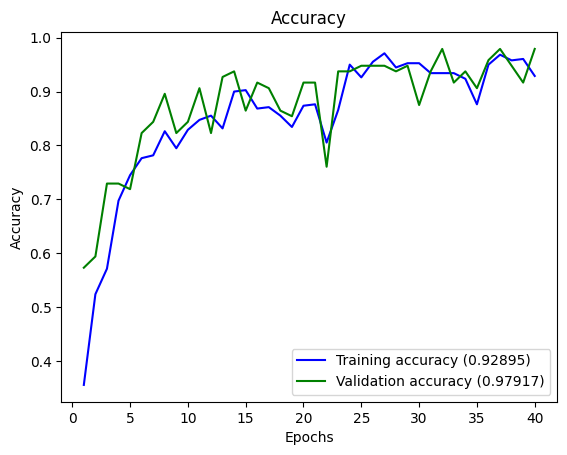

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1, shuffle=True, stratify=y_train)

model = None
history = None
with warnings.catch_warnings(action='ignore'):
    model = create_model(optimizer=grid_result.best_params_['optimizer'])
    history = model.fit(X_train, y_train, batch_size=grid_result.best_params_['batch_size'], epochs=grid_result.best_params_['epochs'], validation_data=(X_val, y_val), verbose=0)

plot_history(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


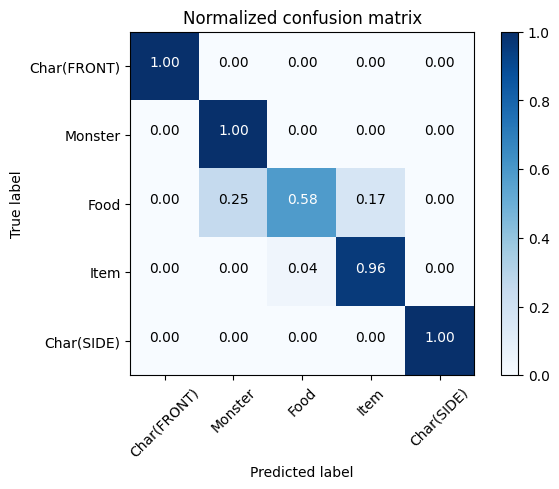

In [10]:
y_pred = model.predict(X_test)
matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(matrix, classes=['Char(FRONT)', 'Monster', 'Food', 'Item', 'Char(SIDE)'], normalize=True)

# A Little Demonstration
Here, I've added a widget to play with to see the results of our model.

In [11]:
import ipywidgets as widgets
label_names = ['Character (FORWARD)', 'Monster', 'Food', 'Item', 'Character (SIDE)']
index_slider = widgets.IntSlider(value=0, min=0, max=len(X_test)-1, description='Image index:', layout=widgets.Layout(width='100%'))
def show_image(index):
    plt.imshow(X_test[index])
    plt.show()
    prediction = model(X[index:index+1]).numpy()
    print(f'Predicted label: {np.argmax(prediction)} ({label_names[np.argmax(prediction)]})')
    print(f'Actual label:    {np.argmax(y_test[index])} ({label_names[np.argmax(y_test[index])]})')
    print('Predicted probabilities:')
    print(f'    Character (FORWARD): {'%.2f' % (prediction[0][0] * 100)}%')
    print(f'    Monster:             {'%.2f' % (prediction[0][1] * 100)}%')
    print(f'    Food:                {'%.2f' % (prediction[0][2] * 100)}%')
    print(f'    Item:                {'%.2f' % (prediction[0][3] * 100)}%')
    print(f'    Character (SIDE):    {'%.2f' % (prediction[0][4] * 100)}%')
widgets.interactive(show_image, index=index_slider)

interactive(children=(IntSlider(value=0, description='Image index:', layout=Layout(width='100%'), max=118), Ou…

# Conclusion & Hindsight
After working through this, the dataset we chose could have been more interesting. This dataset is fairly small, and doesn't have all that much diversity. However, this project has been pretty interesting in terms of being able to observe, learn, and discuss machine learning techniques.

We encountered a lot of issues with how small the dataset actually is. Mainly issues with underfitting/overfitting between different hyperparameters and figuring out why the issue was occuring.